In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import gmplot as gp
from PIL import Image

from xgboost import XGBClassifier
import xgboost
import shap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from scipy.interpolate import LinearNDInterpolator

In [2]:
df = pd.read_csv('data_stephen_fix_header.csv', header=[0])
df = df.drop(df[df['latitude'] >= 69.4475].index)

In [3]:
df.tail()

,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,organic_cover,top_of_interval,bottom_of_interval
2832,68.38262,-133.71211,2013-04-27T00:00:00Z,W14103137-S6-BH15,5.45,1,Nf/Nbn,No visible ice,NaN,Till,0.0,2.7,8.2
2833,68.38262,-133.71211,2013-04-27T00:00:00Z,W14103137-S6-BH15,8.65,1,Nbn,No visible ice,NaN,Till,0.0,8.2,9.1
2834,68.38386,-133.70967,2013-04-27T00:00:00Z,W14103137-S6-BH16,0.05,0,NaN,None,ORGANICS,Organics,0.1,0.0,0.1
2835,68.38386,-133.70967,2013-04-27T00:00:00Z,W14103137-S6-BH16,0.35,0,NaN,None,NaN,Till,0.1,0.1,0.6
2836,68.38386,-133.70967,2013-04-27T00:00:00Z,W14103137-S6-BH16,4.85,1,Nbn,No visible ice,NaN,Till,0.1,0.6,9.1


In [4]:
# df.loc[df['cryostructures'].str.contains('Vx', na=False), 'cryostructures'] = 'Vx'
# df.loc[df['cryostructures'].str.contains('Nf', na=False), 'cryostructures'] = 'Nf'
# df.loc[df['cryostructures'].str.contains('Nbn', na=False), 'cryostructures'] = 'Nbn'
df['cryostructures'] = df['cryostructures'].str.split('/').str[0]
df['cryostructures'].replace(['Vx, Vs'], 'Vx', regex=True, inplace=True)
df['cryostructures'].replace(['Vx, Vc'], 'Vx', regex=True, inplace=True)

In [5]:
# merge materials (target) classes
# types of ice -> ice
# types of till -> till

# df['materials'].replace(['ICE'], 'ice', regex=True, inplace=True)
# df['materials'].replace(['ICE'], 'Ice', regex=True, inplace=True)
# df['materials'].replace(['ice'], 'Ice', regex=True, inplace=True)
# df['materials'].replace(['Pure Ice'], 'Ice', regex=True, inplace=True)

# df['materials'].replace(['Coarse till'], 'Till', regex=True, inplace=True)
# df['materials'].replace(['till'], 'Till', regex=True, inplace=True)
# df['materials'].replace(['Fine till'], 'Till', regex=True, inplace=True)
# df['materials'].replace(['Fine Till'], 'Till', regex=True, inplace=True)

# # df['materials'].replace(['Till'], 'Sand', regex=True, inplace=True)
# # df['materials'].replace(['Silt'], 'Sand', regex=True, inplace=True)

# # df['materials'].replace(['Cobbles'], 'Gravel', regex=True, inplace=True)

# df['visible_ice'].replace(['None'], 'No visible ice', regex=True, inplace=True)


df['materials'].replace(['Pure Ice'], 'Ice', regex=True, inplace=True)

df['materials'].replace(['Coarse till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['Fine till'], 'Till', regex=True, inplace=True)
df['materials'].replace(['Fine Till'], 'Till', regex=True, inplace=True)

df['materials'].replace(['Till'], 'Sand', regex=True, inplace=True)
df['materials'].replace(['Silt'], 'Sand', regex=True, inplace=True)

df['materials'].replace(['Cobbles'], 'Gravel', regex=True, inplace=True)


#df['materials'].replace(['Rock'], 'Gravel', regex=True, inplace=True)

# -------------
df['materials'].replace(['ICE'], 'Ice', regex=True, inplace=True)
df['materials'].replace(['ice'], 'Ice', regex=True, inplace=True)

# print(df.materials.value_counts().index)
# df.materials = df.materials.astype('category').cat.codes
# print(df.materials.value_counts().index)

# convert_to_code('materials')
# convert_to_code('cryostructures')
# convert_to_code('ASTM_2488')

ordered_ice = ['No visible ice', 'Low', "Medium to high", 'High', 'Pure ice']
df['visible_ice'] = pd.Series(pd.Categorical(df['visible_ice'], categories=ordered_ice, ordered=True))
# convert_to_code('visible_ice')


# convert timecodes to year and month columns
datetimes = pd.to_datetime(df['time'])
df['month'] = datetimes.dt.month
df['year'] = datetimes.dt.year

In [6]:
df.materials.nunique()

7

In [7]:
df['interval_length'] = df['bottom_of_interval'] - df['top_of_interval']

In [8]:
def convert_to_code(df, column):
    print(df[column].value_counts().index)
    df[column] = df[column].astype('category').cat.codes
    print(df[column].value_counts().index)

In [9]:
feature_names = ['latitude', 'longitude', 'year', 'month', 'depth', 'interval_length'] #, 'organic_cover']

## Plot visible ice mean over depth

In [10]:
# df = df.dropna(subset=['visible_ice'])
# convert_to_code(df, 'visible_ice')

In [11]:
# visible_ice_mean = df.groupby(['borehole'])['visible_ice'].mean().values

In [12]:
df_unique = df.drop_duplicates(subset='borehole')

In [13]:
# df_unique['visible_ice_mean'] = visible_ice_mean

In [14]:
# plt.scatter(df_unique.longitude, df_unique.latitude, c = visible_ice_mean)
# plt.axis('equal')
# plt.colorbar()

## xgboost stuff

In [15]:
print(df.latitude.max())
print(df.latitude.min())
print(df.longitude.max())
print(df.longitude.min())

69.34394
68.36933
-132.89346
-133.82843


In [16]:
def xgboost_shap(label_name):
    df_temp = df.dropna(subset=[label_name])
    convert_to_code(df_temp, label_name)
    data = np.array(df_temp.filter(feature_names))
    labels = df_temp[label_name]

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2) #, random_state=0

    classifier = XGBClassifier()
    classifier.fit(X_train, y_train) 

    y_pred = classifier.predict(X_test)

    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))

    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(data)

    shap.summary_plot(shap_values, plot_type="bar", feature_names=feature_names, show=False)
    plt.title(label_name)
    plt.show()

In [17]:
def xgboost_shap_layers(label_name, depth_top, depth_bottom=1000):
    df_temp = df.dropna(subset=[label_name])
    
    df_temp = df_temp.loc[(df_temp['depth'] >= depth_top) & (df_temp['depth'] <= depth_bottom)]
    
    convert_to_code(df_temp, label_name)
    data = np.array(df_temp.filter(feature_names))
    labels = df_temp[label_name]

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3) #, random_state=0

    classifier = XGBClassifier()
    classifier.fit(X_train, y_train) 

    y_pred = classifier.predict(X_test)

    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))

    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(data)
        
    shap.summary_plot(shap_values, plot_type="bar", feature_names=feature_names, show=False)
    plt.title(label_name)
    plt.show()

In [18]:
def xgboost_shap_train_all_layers(label_name, depth_top, depth_bottom=1000):
    df_temp = df.dropna(subset=[label_name])
    
    convert_to_code(df_temp, label_name)
    data = np.array(df_temp.filter(feature_names))
    labels = df_temp[label_name]

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3) #, random_state=0
    
    print((X_test['depth'] >= depth_top) & (X_test['depth'] <= depth_bottom))
#     X_test = X_test.loc[(X_test['depth'] >= depth_top) & (X_test['depth'] <= depth_bottom)]
#     Y_test = Y_test.loc[(X_test['depth'] >= depth_top) & (X_test['depth'] <= depth_bottom)]

    classifier = XGBClassifier()
    classifier.fit(X_train, y_train) 

    y_pred = classifier.predict(X_test)

    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print(accuracy_score(y_test, y_pred))

    explainer = shap.TreeExplainer(classifier)
    shap_values = explainer.shap_values(data)
    print("shap_values shape is:")
    print(np.array(shap_values).shape)
    shap.summary_plot(shap_values, plot_type="bar", feature_names=feature_names, show=False)
    plt.title(label_name)
    plt.show()

## visualize layers

In [19]:
label_name = 'frozen'
df_temp = df.dropna(subset=[label_name])
convert_to_code(df_temp, label_name)
data = np.array(df_temp.filter(feature_names))
labels = df_temp[label_name]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2) #, random_state=0

classifier = XGBClassifier()
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

Int64Index([1, 0], dtype='int64')
Int64Index([1, 0], dtype='int64')
[18:01:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 64  18]
 [  9 473]]
              precision    recall  f1-score   support

           0       0.88      0.78      0.83        82
           1       0.96      0.98      0.97       482

    accuracy                           0.95       564
   macro avg       0.92      0.88      0.90       564
weighted avg       0.95      0.95      0.95       564

0.9521276595744681


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [20]:
feature_names

['latitude', 'longitude', 'year', 'month', 'depth', 'interval_length']

In [21]:
latitude_max = 69.5
latitude_min = 68.3
longitude_max = -132.8
longitude_min = -133.9
# latitude_max = df.latitude.max()
# latitude_min = df.latitude.min()
# longitude_max = df.longitude.max()
# longitude_min = df.longitude.min()

n_lat = 80
n_lng = 40

lng_range = np.linspace(longitude_min, longitude_max, n_lng)
lat_range = np.linspace(latitude_min, latitude_max, n_lat)
depth_range = [1, 3, 5, 7, 9]
grid_lng, grid_lat, grid_depth = np.meshgrid(lng_range, lat_range, depth_range)
X_syn = np.zeros([len(grid_lng.flatten()), len(feature_names)])


In [22]:
X_syn.shape

(16000, 6)

In [23]:
X_syn[:, 0] = grid_lat.flatten() # latitude
X_syn[:, 1] = grid_lng.flatten() # longitude
X_syn[:, 2] = 2013 # year
X_syn[:, 3] = 3 # month
X_syn[:, 4] = grid_depth.flatten() # depth
X_syn[:, 5] = 2 # interval length

In [24]:
Y_syn = classifier.predict(X_syn)

In [25]:
Y_syn_reshaped = Y_syn.reshape(n_lng, n_lat, len(depth_range))

In [26]:
Y_syn_reshaped.shape

(40, 80, 5)

In [27]:
Y_syn_sum = np.sum(Y_syn_reshaped, axis=-1)

## plot layers on map

In [28]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import to_hex

Text(0.5, 1.0, 'Sum of depth layers')

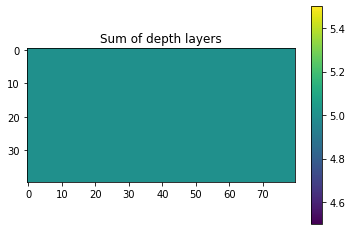

In [29]:
plt.imshow(Y_syn_sum)
plt.rcParams['figure.figsize'] = [5,5]
plt.colorbar()
plt.title("Sum of depth layers")

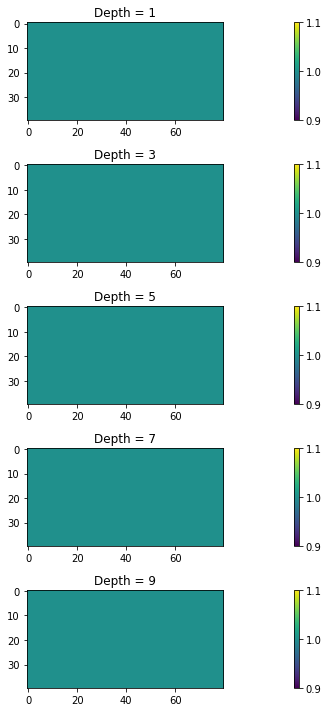

In [30]:
plt.rcParams['figure.figsize'] = [20, 10]
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.imshow(Y_syn_reshaped[:,:,i])
    plt.colorbar()
    plt.title('Depth = {}'.format(depth_range[i]))

plt.tight_layout()
plt.savefig('xgboost_predicted_depth_layers.png')

In [31]:
import gmplot as gp

mean_lat = df.latitude.unique().mean()
mean_lng = df.longitude.unique().mean()

grid_lng_2d, grid_lat_2d = np.meshgrid(lng_range, lat_range)
grid_lng_2d = grid_lng_2d.flatten()
grid_lat_2d = grid_lat_2d.flatten()

grid_lat_2d.shape

(3200,)

In [32]:
predicted_2d = Y_syn_reshaped[:, :, 0]
predicted_2d = predicted_2d.flatten()
ocean = cm.get_cmap('inferno',predicted_2d.max())
color_ice = ocean(predicted_2d)
len(color_ice)

3200

In [33]:
color_ice_hex = [None] * len(color_ice)

In [34]:
color_ice[0]

array([1.4620e-03, 4.6600e-04, 1.3866e-02, 1.0000e+00])

In [35]:
for i, color in enumerate(color_ice):
    color_ice_hex[i] = to_hex(color)

## xgboost train on all layers, test on single layer

In [36]:
current_label_name = 'visible_ice'

In [37]:
#xgboost_shap_train_all_layers(current_label_name, 0, 2.5)

## xgboot with depth layers

CategoricalIndex(['Medium to high', 'No visible ice', 'Low', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([2, 0, 1, 4, 3], dtype='int64')
[18:01:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[56 17 14  0  3]
 [14 25 25  2  1]
 [ 8 23 51  0  5]
 [ 0  4  4  0  0]
 [ 8  2 12  0  0]]
              precision    recall  f1-score   support

           0       0.65      0.62      0.64        90
           1       0.35      0.37      0.36        67
           2       0.48      0.59      0.53        87
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        22

    accuracy                           0.48       274
   macro avg       0.30      0.32      0.31       274
weighted avg       0.45      0.48      0.47       274

0.48175182481751827


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


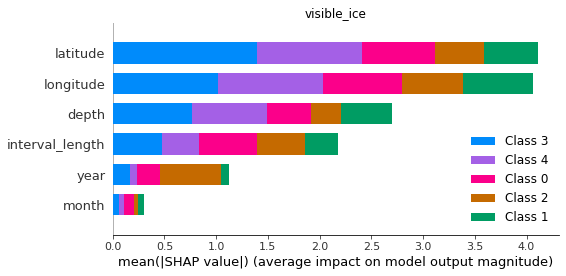

In [38]:
xgboost_shap_layers(current_label_name, 0, 2.5)

CategoricalIndex(['Low', 'No visible ice', 'Medium to high', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([1, 0, 2, 4, 3], dtype='int64')
[18:01:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[24 10 10  0  8]
 [16 21 19  3  6]
 [11 18 14  1  5]
 [ 0  4  0  0  1]
 [13 14  1  0 11]]
              precision    recall  f1-score   support

           0       0.38      0.46      0.41        52
           1       0.31      0.32      0.32        65
           2       0.32      0.29      0.30        49
           3       0.00      0.00      0.00         5
           4       0.35      0.28      0.31        39

    accuracy                           0.33       210
   macro avg       0.27      0.27      0.27       210
weighted avg       0.33      0.33      0.33       210

0.3333333333333333


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


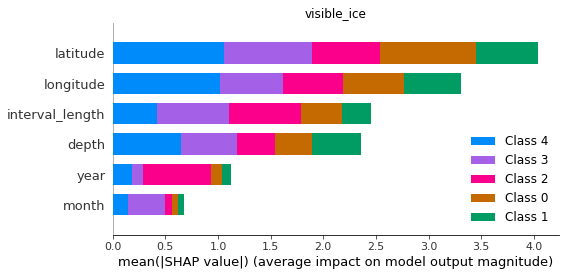

In [39]:
xgboost_shap_layers(current_label_name, 2.5, 5)

CategoricalIndex(['Low', 'No visible ice', 'Medium to high', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([1, 0, 2, 4, 3], dtype='int64')
[18:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[19 11  5  0  0]
 [14 11 13  3  1]
 [ 8  9  9  0  3]
 [ 0  1  1  0  0]
 [ 9  7  4  0  3]]
              precision    recall  f1-score   support

           0       0.38      0.54      0.45        35
           1       0.28      0.26      0.27        42
           2       0.28      0.31      0.30        29
           3       0.00      0.00      0.00         2
           4       0.43      0.13      0.20        23

    

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



0.32061068702290074


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


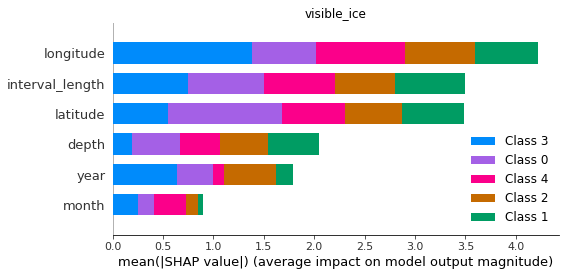

In [40]:
xgboost_shap_layers(current_label_name, 5, 7.5)

CategoricalIndex(['Low', 'No visible ice', 'Medium to high', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([1, 0, 2, 4, 3], dtype='int64')
[18:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[10  7  4  0  2]
 [10  8 12  0  1]
 [ 6  3  8  0  2]
 [ 0  0  1  0  0]
 [ 4  1  0  0  1]]
              precision    recall  f1-score   support

           0       0.33      0.43      0.38        23
           1       0.42      0.26      0.32        31
           2       0.32      0.42      0.36        19
           3       0.00      0.00      0.00         1
           4       0.17      0.17      0.17         6

    

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


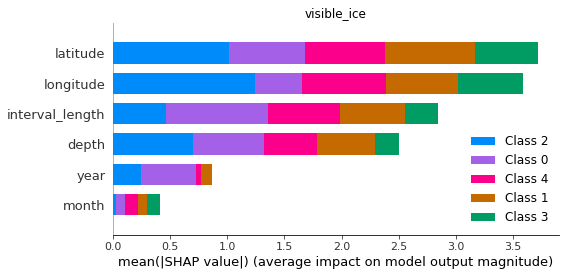

In [41]:
xgboost_shap_layers(current_label_name, 7.5, 10)

CategoricalIndex(['Low', 'Medium to high', 'No visible ice', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([1, 2, 0, 4, 3], dtype='int64')
[18:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 2  8  1  0  0]
 [ 2 10  3  0  1]
 [ 1 11  4  0  1]
 [ 1  0  1  0  0]
 [ 0  2  0  0  0]]
              precision    recall  f1-score   support

           0       0.33      0.18      0.24        11
           1       0.32      0.62      0.43        16
           2       0.44      0.24      0.31        17
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2

    

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


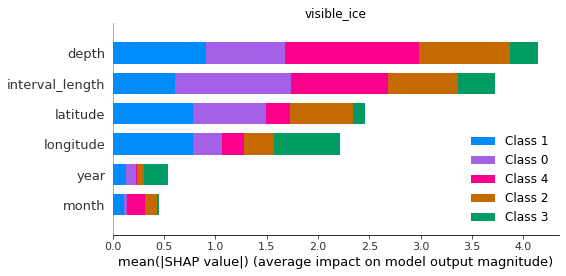

In [42]:
xgboost_shap_layers(current_label_name, 10)

## xgboost without depth layers


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


CategoricalIndex(['Low', 'Medium to high', 'No visible ice', 'Pure ice',
                  'High'],
                 categories=['No visible ice', 'Low', 'Medium to high', 'High', 'Pure ice'], ordered=True, dtype='category')
Int64Index([2, 1, 0, 4, 3], dtype='int64')
[18:01:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[72 29 24  1  3]
 [30 51 45  2  9]
 [25 33 83  1  9]
 [ 3  7  9  1  0]
 [11 10 14  0 18]]
              precision    recall  f1-score   support

           0       0.51      0.56      0.53       129
           1       0.39      0.37      0.38       137
           2       0.47      0.55      0.51       151
           3       0.20      0.05      0.08        20
           4       0.46      0.34      0.39        53

    

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


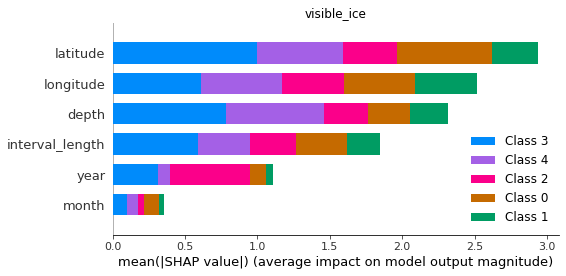

In [43]:
xgboost_shap('visible_ice')

In [44]:
y_pred = classifier.predict(X_test)

Index(['Sand', 'Clay', 'Organics', 'Ice', 'Gravel', 'Rock', 'Pure Ice'], dtype='object')
Int64Index([6, 0, 3, 2, 1, 5, 4], dtype='int64')
[18:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[ 66   0  11   2   0  42]
 [  1  12   1   1   0  26]
 [  7   2  10   4   0  24]
 [  1   0   0  80   0  16]
 [  0   0   0   0   2   1]
 [ 30  15   7   7   0 196]]
              precision    recall  f1-score   support

           0       0.63      0.55      0.58       121
           1       0.41      0.29      0.34        41
           2       0.34      0.21      0.26        47
           3       0.85      0.82      0.84        97
           5       1.00      0.67      0.80         3
           6       0.64      0.77      0.70       255

    accuracy                           0.65       564
   macro avg       0.65      0.55      0.59       564
weighted avg       0.64      0.65      0.64       564

0.648936170212766


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


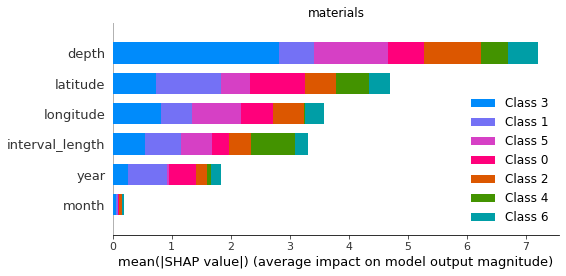

In [45]:
xgboost_shap('materials')

Index(['Vx', 'Nf', 'Nbn', 'Nbe', 'Vs', 'Vr', 'Vc'], dtype='object')
Int64Index([6, 2, 1, 0, 5, 4, 3], dtype='int64')
[18:01:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[ 2  6  3  0  0  0  6]
 [ 4 14 13  0  2  0 28]
 [ 3 15 52  1  0  0 26]
 [ 0  0  3  1  0  0  5]
 [ 0  2  0  2  2  0  7]
 [ 0  1  1  0  0  1 11]
 [ 4 25 23  1  1  1 93]]
              precision    recall  f1-score   support

           0       0.15      0.12      0.13        17
           1       0.22      0.23      0.23        61
           2       0.55      0.54      0.54        97
           3       0.20      0.11      0.14         9
           4       0.40      0.15      0.22        13
           5       0.50      0.07      0.12        14
           6       0.53      0.63      0.57       148

    accuracy                           0.46       359
   macro avg       0.36      0.26      0.28       359
weighted avg       0.45      0.46      0.44       359

0.4596100278551532


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


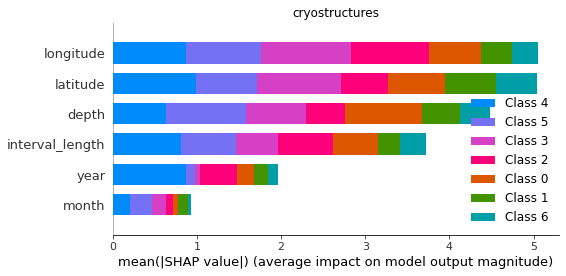

In [46]:
xgboost_shap('cryostructures')

Int64Index([1, 0], dtype='int64')
Int64Index([1, 0], dtype='int64')
[18:01:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 48  21]
 [  5 490]]
              precision    recall  f1-score   support

           0       0.91      0.70      0.79        69
           1       0.96      0.99      0.97       495

    accuracy                           0.95       564
   macro avg       0.93      0.84      0.88       564
weighted avg       0.95      0.95      0.95       564

0.9539007092198581


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


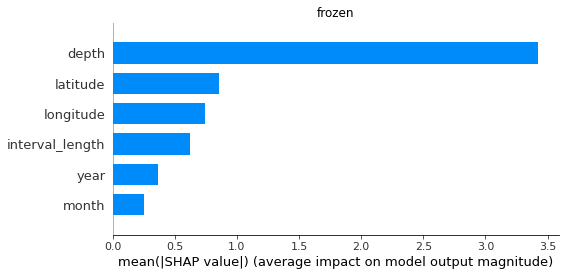

In [47]:
xgboost_shap('frozen')

Index(['CL', 'ICE', 'PEAT', 'ML', 'ORGANICS', 'SM', 'SP', 'SC', 'TOPSOIL',
       'CL-ML', 'GP-GM', 'SC-SM', 'SP-SM', 'TILL', 'GP', 'CH', 'GW', 'GW-GM',
       'SM-SC', 'SW', 'GM', 'SW-SM', 'GC', 'GP-GC', 'GM-GC', 'MH', 'SP-SC',
       'SW-SC', 'GC-GM', 'SP-SW', 'GW-GC', 'SW-SP', 'COBBLES', 'ROCK', 'ML-CL',
       'SP-GP', 'SW-GC', 'ML-SM'],
      dtype='object')
Int64Index([ 1, 14, 20, 16, 19, 24, 26, 22, 37,  2, 10, 23, 29, 36,  8,  0, 11,
            25, 13, 31,  6, 34,  4, 15,  9,  7, 28, 33,  5, 30, 12, 17, 21,  3,
            35, 32, 27, 18],
           dtype='int64')
[18:01:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[ 3  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  1  0
   0  1  0  0  0  0]
 [ 0 41  1  0  0  1  0  1  0  0  0  3  0  2  0  1  0  0  6  0  1  0  0  0
   0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0  0  3  0  2  0  0  1  0  0  5  2  0  0  0
   0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  1  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  1  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  1  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  1  0  0  0  2  0  1  0  0  0  0  0  0  1  0
   0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  2  2  0  0  0  0  0  0  0  0  0  3  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  1  0  0  0  0  0  0  0  0  1  0  2  0
   0  1  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1  2  2  0  0  0  0 

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


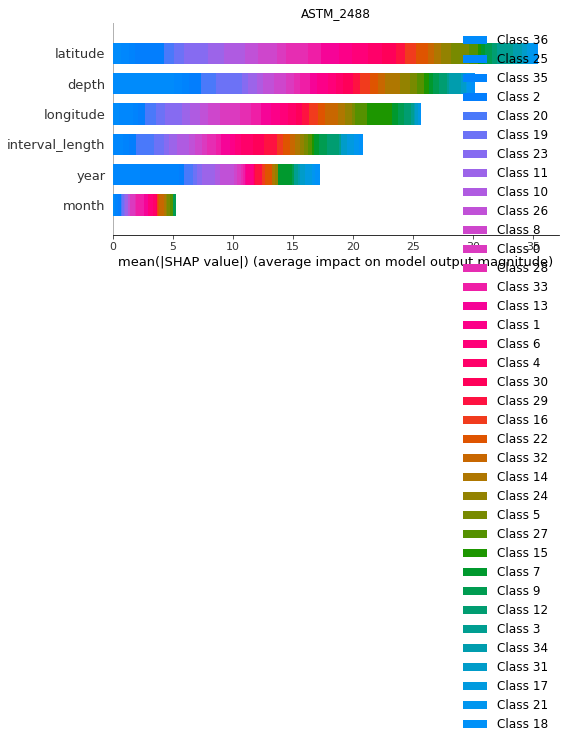

In [48]:
xgboost_shap('ASTM_2488')

In [49]:
label_name = 'materials'
df_temp = df.dropna(subset=[label_name])

convert_to_code(df_temp, label_name)
data = np.array(df_temp.filter(feature_names))
labels = df_temp[label_name]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3) #, random_state=0

# print((X_test['depth'] >= depth_top) & (X_test['depth'] <= depth_bottom))
#     X_test = X_test.loc[(X_test['depth'] >= depth_top) & (X_test['depth'] <= depth_bottom)]
#     Y_test = Y_test.loc[(X_test['depth'] >= depth_top) & (X_test['depth'] <= depth_bottom)]

Index(['Sand', 'Clay', 'Organics', 'Ice', 'Gravel', 'Rock', 'Pure Ice'], dtype='object')
Int64Index([6, 0, 3, 2, 1, 5, 4], dtype='int64')


[18:01:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[[ 91   1   7   5   0   0  67]
 [  0  16   2   3   0   0  47]
 [ 17   5  16   0   0   0  48]
 [  4   0   3  99   0   0  20]
 [  0   0   1   0   0   0   0]
 [  0   0   0   0   0   1   1]
 [ 45  16  14  11   0   0 306]]
              precision    recall  f1-score   support

           0       0.58      0.53      0.55       171
           1       0.42      0.24      0.30        68
           2       0.37      0.19      0.25        86
           3       0.84      0.79      0.81       126
           4       0.00      0.00      0.00         1
           5       1.00      0.50      0.67         2
           6       0.63      0.78      0.69       392

    accuracy                           0.63       846
   macro avg       0.55      0.43      0.47       846
weighted avg       0.61      0.63      0.61       846

0.6252955082742316


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


shap_values shape is:
(6, 2819, 6)


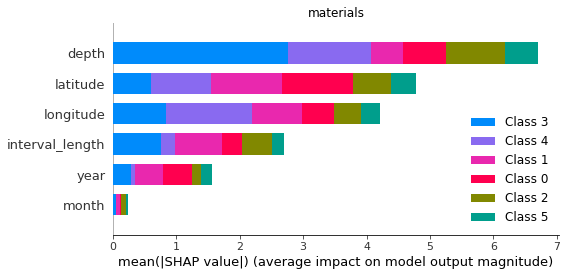

In [50]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train) 

y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(data)
print("shap_values shape is:")
print(np.array(shap_values).shape)
type(shap_values)

shap.summary_plot(shap_values, plot_type="bar", feature_names=feature_names, show=False)
plt.title(label_name)
plt.show()

In [51]:
print(type(shap_values))

<class 'list'>


In [52]:
type(shap_values[0])

numpy.ndarray